In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

In [4]:
np.random.seed(2020)

## Model Parameters

In [79]:
N_train = 10000
N_test = 50000
d = 6
T = 2


In [80]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

In [82]:
def reconstruct_alpha(length_scale):
    return 1/(2*(length_scale**2))
def reconstruct_lambda(noise_level, N):
    return noise_level/N

## Kernel Construction

In [83]:
#Kernel Construction, doubt on the lambda hyperparameter
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2, noise_level_bounds=lambda_range)
kernel.get_params()


{'k1': RBF(length_scale=39.2),
 'k2': WhiteKernel(noise_level=5),
 'k1__length_scale': 39.195601548169805,
 'k1__length_scale_bounds': array([ 0.77615053, 77.61505257]),
 'k2__noise_level': 5.000005,
 'k2__noise_level_bounds': (1e-05, 10.0)}

## Data Generation (Test, Train sets)

In [84]:
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [85]:
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S



In [86]:
y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = s_test.generate_true_V(T)
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.27506913010690065

## Data Flattening 

In [87]:
def Flatten_Training_Sample(X , f):
    return np.array([f(x) for x in X])

In [88]:
#Shape of each sample j: [X_j[0,0],... ,X_j[d,0],...,X_j[0,T] , ..., X_j[d,T]]
Flatten_X_1_train = Flatten_Training_Sample(X_train, lambda x : x.T.flatten())
Flatten_X_1_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())


In [89]:
Flatten_X_1_train.shape

(10000, 12)

In [90]:
Flatten_X_1_test.shape

(50000, 12)

## Model Fitting

In [91]:
#Model with Flatten_X_1
m_1 = GaussianProcessRegressor(kernel)
m_1.fit(Flatten_X_1_train,y_train)
#fX_1,sigma_1 = m_1.predict(Flatten_X_1_test,return_std= True)

GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=5))

In [97]:
print(m_1.kernel_.get_params())

{'k1': RBF(length_scale=5.06), 'k2': WhiteKernel(noise_level=0.0009), 'k1__length_scale': 5.060821257962101, 'k1__length_scale_bounds': array([ 0.77615053, 77.61505257]), 'k2__noise_level': 0.0008997934088747651, 'k2__noise_level_bounds': (1e-05, 10.0)}


In [35]:
fX_1,sigma_1 = m_1.predict(Flatten_X_1_test,return_std= True)

In [125]:
indices = np.random.choice(Flatten_X_1_train.shape[0], int(N_train*1.02), replace=True)
m_1.fit(Flatten_X_1_train[indices],y_train[indices])
fX_2,sigma_2 = m_1.predict(Flatten_X_1_test,return_std=True)

In [126]:
## see if there is a difference when adding same points multiple times
diff_y = np.sqrt(np.sum((fX_1-fX_2)**2)/Flatten_X_1_train.shape[0])
diff_s = np.sqrt(np.sum((sigma_1-sigma_2)**2)/Flatten_X_1_train.shape[0])
diff_y
## --> there is a difference which means bagging will enhance variety in the different trainsets when ussing aggregating
### 0.004 for normal lambda range & 5000

0.013597744147797514

## Optimal Hyperparameters

In [127]:
optimal_alpha,optimal_lambda = reconstruct_alpha(np.exp(m_1.kernel.theta[0])),reconstruct_lambda(np.exp(m_1.kernel.theta[1]), N_train)
print(f"optimal alpha = {optimal_alpha}, optimal lambda = {optimal_lambda}")

optimal alpha = 0.00032545828840309794, optimal lambda = 0.0005000005


## Error Calculation

In [128]:
normalized_train_error = np.sqrt(1/N_test*np.sum((m_1.predict(Flatten_X_1_train)-y_train)**2, axis=0))/V_0
print(normalized_train_error)
# 0.014408884145825963 with standard lambda range

0.02222508678320298


In [129]:
Normalized_Error_T_1 = np.sqrt(1/N_test*np.sum((fX_1-V_T)**2, axis=0))/V_0
## see formula p4 for ||f(X)||2,Q 
## since samples are drawn according to measure - just sum them up
print(Normalized_Error_T_1)


0.16808426938938256


In [130]:
print(f" normalized error on V_T = {100*Normalized_Error_T_1} %")

 normalized error on V_T = 16.808426938938258 %


## Visualisation

5145


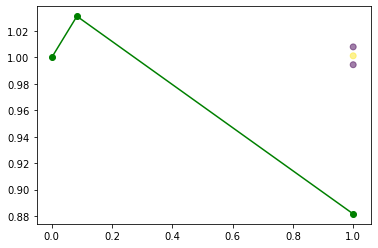

In [131]:
# take one test instance and plot prediction of VX,T = fX
index = np.random.randint(0, X_test.shape[0]) 
print(index)
x = X_test[index]
y = y_test[index]
# plot stock prices
S = S_test[index][0]
vt = V_T[index]

f_pred, sigma = m_1.predict(x, return_std=True)
time = [0,1/12,1]
plt.plot(time,S,"g-o")
plt.scatter([1,1,1],[f_pred + 1-3*sigma, f_pred+1, f_pred+1+3*sigma],c=[0.9,1,0.9],alpha=0.5) ## add K
plt.show()

-4


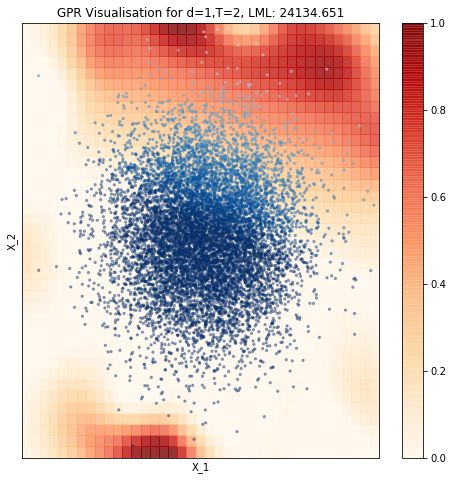

In [132]:
#Plot Kernel
h = 0.2

x_min, x_max = -4,4
y_min, y_max = -4,4
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
print(x_min)
title= "GPR Visualisation for d=1,T=2"
plt.figure(figsize=(8, 8))
# Plot the predicted probabilities. For that, we will assign a color to
# each point in the mesh [x_min, m_max]x[y_min, y_max].

Z = m_1.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.subplot(1,1,1)
a = plt.pcolor(xx,yy,Z, vmin=0, vmax=1,cmap='OrRd',alpha=0.8)
plt.colorbar(a)
# Plot also the training points
plt.scatter(X_test[:,0, 0], X_test[:,0, 1],c=1-y_test,cmap="Blues",alpha=0.4,s=5)
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("%s, LML: %.3f" %
          (title, m_1.log_marginal_likelihood(m_1.kernel_.theta)))

plt.show()